In [1]:
!pip install -e .
!pip install spacy
!python3 -m spacy download en_core_web_lg
!pip install pandas
!pip install openpyxl
!pip install beautifulsoup4
!mkdir extractions
!mkdir extractions/gpt3.5_1106
!mkdir finetuned_extractions
!mkdir finetuned_extractions/epoch10/gpt3.5_125_1106_withoutdescription
!pip install sentence_transformers
!mkdir gpt_evaluation
!mkdir gpt_evaluation/without_description
!pip install bert_score
!pip install python-dotenv


Obtaining file:///Users/rajashreedahal/Desktop/Metadata_Finetuning/larch
  Installing build dependencies ... done
  Checking if build backend supports build_editable ... done
  Getting requirements to build editable ... done
  Preparing editable metadata (pyproject.toml) ... done
  Building editable for larch (pyproject.toml) ... done
  Created wheel for larch: filename=larch-0.0.2a0-0.editable-py3-none-any.whl size=14420 sha256=83cf703024c8060dd4d01df01e1bea76a0f2b7fe58bd78241c509a2e584cdfa4
  Stored in directory: /private/var/folders/m4/9_ydsvdn3b3d84rntrrsxm0h0000gn/T/pip-ephem-wheel-cache-o83jn3v0/wheels/3a/98/39/46f8f1efc02842106044493327f82ab1f2c43a0a7f389a1df9
Successfully built larch
  Attempting uninstall: larch
    Found existing installation: larch 0.0.2a0
    Uninstalling larch-0.0.2a0:
      Successfully uninstalled larch-0.0.2a0

[notice] A new release of pip available: 22.2.2 -> 24.0
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip availa

# Download the documents in this drive: https://drive.google.com/drive/u/1/folders/1z3fui-tKdsxPC3gYMqmMSUnzzrwC4UVB

# Initial Extractions

In [2]:
import pandas as pd
from larch.metadata import InstructorBasedOpenAIMetadataExtractor
from larch.processors import PIIRemover, TextProcessingPipeline

from dotenv import load_dotenv
import os
# Load environment variables from .env file
load_dotenv()
# Access the API key from the environment
openai_api_key = os.getenv("OPENAI_API_KEY")
text_processor = TextProcessingPipeline(
    lambda x: re.sub(r"\$(?=\w|\n|\()", " ", x).strip(),
    lambda x: re.sub(r"\)(?=\w|\n|\()", " ", x).strip(),
    lambda x: re.sub(r"\#(?=\w|\n|\()", " ", x).strip(),
    lambda x: x.replace("\t", " ").replace("!", " ").strip(),
    PIIRemover()
)
import re
import requests
from bs4 import BeautifulSoup

from pydantic import BaseModel,constr,Field
from typing import Literal

class Environmental_Justice(BaseModel):
    Indicators: Literal["Disasters","Human Dimensions","Food Availability","Health & Air Quality","Water Availability", "Extreme Heat","Urban Flooding","Climate"]
    Description: str
    Geographic_Coverage: str =Field(pattern=r'')
    Format: str
    Spatial_Resolution: str = Field(pattern=r'^(\d+(\.\d+)? [a-zA-Z]+|varies|N/A)$')
    Temporal_Resolution: str = Field(pattern=r'^(\d+(\.\d+)? [a-zA-Z]+|N/A|varies|weekly|monthly|daily|yearly|varies-multiple datasets included|Daily < Weekly|Hourly < Daily|Weekly < Monthly|Monthly < Yearly|1 minute)$')
    Temporal_Extent: str = Field(pattern=r'^(\d{4}-\d{2}-\d{2} to present|present|\d{4}-\d{2}-\d{2} (?:to|until) present|\d{4}-\d{2}-\d{2} to \d{4}-\d{2}-\d{2}|varies(?:- multiple datasets (?:included|available))?)$')
    Latency: str = Field(pattern=r'^\d+(\s*(Day|days|months|NRT))?$')
    Project: str
    Data_Visualization: bool


    
schema = Environmental_Justice
sheet_names=["Water Availability - Cleaned", "Disasters (Disaster Recovery) -", 
 "Food Availability - Cleaned", "Human Dimensions - Cleaned", "Urban Flooding - Cleaned",
 "Extreme Heat - CIP","Climate (Climate Change) - CIP","Health and Air Quality - CIP"]

spacy is loaded


# Initial Extractions

In [9]:
used_urls=[]
for each_sheet in sheet_names:
    mapper = pd.read_excel("nasa_esds.xlsx", sheet_name=[each_sheet])
    res = {}
    url_lists=[]
    for field_key, value_df in mapper.items():
        res[field_key] = {}
        cols = value_df.columns
        for i, row in value_df.iterrows():
            source_link_col = [col for col in cols if col == "Source/Link"]
            alternate_vals = filter(None, row[source_link_col])
            alternate_vals=list(alternate_vals)
            if alternate_vals and str(alternate_vals[0]).startswith("http"):
                url_lists.append(alternate_vals[0])

    url_content=[]
    urls=[]
    count=0
    for url in url_lists:  
        response=requests.get(url)
        html_page = response.text
        soup = BeautifulSoup(html_page, "html.parser")
        text=soup.get_text()
        text = re.sub(r'[\t\n\r\f\v]+', '', text)
        text=re.sub(r'[^\w\s]', '', text)
        if url not in used_urls:
            url_content.append(text)
            urls.append(url.strip())
        used_urls.append(url)


    import json

    metadata_extractor = InstructorBasedOpenAIMetadataExtractor(
        model="gpt-3.5-turbo-1106",
        schema=schema,
        preprocessor=text_processor,
        debug=True,
    )

    response_result={}
    for enum,text in enumerate(url_content):
        split=text.split()
        if len(split)>1900:
            text=" ".join(split[0:1900])
        metadata = metadata_extractor(text)
        response=json.loads((metadata['choices'][0]['message']["function_call"]["arguments"]))
        response_result[urls[enum]]=response
    with open("extractions/gpt3.5_1106/"+each_sheet+".json",'w') as file:
            json.dump(response_result,file,indent=4)


2024-02-26 13:08:39.502 | DEBUG    | larch.metadata.extractors_openai:_extract:79 - nchars=8105
Text :: LP DAAC  GFSAD30AFCEHomeAboutAbout LP DAAC                                                                                                    News Archive                                                                                                    DataGet Started with Data                                                                                                    Search Data Catalog                                                                                                    Data Citations and Policies                                                                                                    View All DataToolsAppEEARSData PoolData Prep ScriptsNASA Earthdata SearchUSGS EarthExplorerView All ToolsResourcesData in Action                                                                                                    ELearning                                  

The schema is <class '__main__.Environmental_Justice'>
the system prompt is Extract metadata and entities details accurately from my requests.Metadata extraction for Indicators should clearly be one of the element in the list [“Disasters”,“Human Dimensions”,“Food Availability”,“Health & Air Quality”,“Water Availability”, “Extreme Heat”,“Urban Flooding”,“Climate]. Do not create new element for indicators Make sure the following fields follow the following regex patternSpatial_Resolution: ^(\d+(\.\d+)? [a-zA-Z]+|varies|N/A)$Temporal_Resolution: ^(\d+(\.\d+)? [a-zA-Z]+|N/A|varies|weekly|monthly|daily|yearly|varies-multiple datasets included|Daily < Weekly|Hourly < Daily|Weekly < Monthly|Monthly < Yearly|1 minute)$Temporal_Extent: ^(\d{4}-\d{2}-\d{2} to present|present|\d{4}-\d{2}-\d{2} (?:to|until) present|\d{4}-\d{2}-\d{2} to \d{4}-\d{2}-\d{2}|varies(?:- multiple datasets (?:included|available))?)$
The messages is [{'role': 'system', 'content': 'Extract metadata and entities details accu

2024-02-26 13:08:51.203 | DEBUG    | larch.metadata.extractors_openai:_extract:79 - nchars=11034
Text :: NASA SVS  NASAs Black Marble night lights used to examine disaster recovery in Puerto RicoScientific Visualization Studio Galleries Help  12469 PACE Satellite Animations4698 Earth Observing Fleet October 2018NASAs Black Marble night lights used to examine disaster recovery in Puerto RicoReleased Sunday December 9th 2018Updated Wednesday November 15th 2023 at 1212AMID 4658Visualizations byKel ElkinsView full creditsAt night Earth is lit up in bright strings of roads dotted with pearllike cities and towns as humanmade artificial light takes center stage During Hurricane Maria Puerto Ricos lights went outIn the days weeks and months that followed research physical scientist <NAME> at NASAs Goddard Space Flight Center in Greenbelt Maryland and his colleagues combined NASAs Black Marble night lights data product from the NASANOAA Suomi National Polarorbiting Partnership satellite with US

the system prompt is Extract metadata and entities details accurately from my requests.Metadata extraction for Indicators should clearly be one of the element in the list [“Disasters”,“Human Dimensions”,“Food Availability”,“Health & Air Quality”,“Water Availability”, “Extreme Heat”,“Urban Flooding”,“Climate]. Do not create new element for indicators Make sure the following fields follow the following regex patternSpatial_Resolution: ^(\d+(\.\d+)? [a-zA-Z]+|varies|N/A)$Temporal_Resolution: ^(\d+(\.\d+)? [a-zA-Z]+|N/A|varies|weekly|monthly|daily|yearly|varies-multiple datasets included|Daily < Weekly|Hourly < Daily|Weekly < Monthly|Monthly < Yearly|1 minute)$Temporal_Extent: ^(\d{4}-\d{2}-\d{2} to present|present|\d{4}-\d{2}-\d{2} (?:to|until) present|\d{4}-\d{2}-\d{2} to \d{4}-\d{2}-\d{2}|varies(?:- multiple datasets (?:included|available))?)$
The messages is [{'role': 'system', 'content': 'Extract metadata and entities details accurately from my requests.Metadata extraction for Indicat

2024-02-26 13:08:55.001 | DEBUG    | larch.metadata.extractors_openai:_extract:79 - nchars=4753
Text :: SSPs Literature Database v1 Shared Socioeconomic Pathways SSPs  SEDAC Socioeconomic Data and Applications Center sedacA Data Center in NASAs Earth Observing System Data and Information System EOSDIS  Hosted by CIESIN at Columbia UniversitySearch SEDACDataData SetsMapsWeb Pagessearch Data Data Sets Data Collections Featured Data Uses Data Citations Citations Database Data SubmissionMaps Map Gallery Map Viewer Map Services Mapping ToolsThemes Agriculture Climate Conservation Governance Hazards Health Infrastructure Land Use Marine and Coastal Population Poverty Remote Sensing Sustainability Urban WaterResources Guides Multimedia Networks News Publications Related Sites Remote Sensing ToolsSocial Media Twitter FaceBook YouTube Flickr Blog Posts CommunitiesAbout About SEDAC User Working Group Privacy User RegistrationHelp Shared Socioeconomic Pathways SSPs  Follow Us TwitterFollow Us on 

The schema is <class '__main__.Environmental_Justice'>
the system prompt is Extract metadata and entities details accurately from my requests.Metadata extraction for Indicators should clearly be one of the element in the list [“Disasters”,“Human Dimensions”,“Food Availability”,“Health & Air Quality”,“Water Availability”, “Extreme Heat”,“Urban Flooding”,“Climate]. Do not create new element for indicators Make sure the following fields follow the following regex patternSpatial_Resolution: ^(\d+(\.\d+)? [a-zA-Z]+|varies|N/A)$Temporal_Resolution: ^(\d+(\.\d+)? [a-zA-Z]+|N/A|varies|weekly|monthly|daily|yearly|varies-multiple datasets included|Daily < Weekly|Hourly < Daily|Weekly < Monthly|Monthly < Yearly|1 minute)$Temporal_Extent: ^(\d{4}-\d{2}-\d{2} to present|present|\d{4}-\d{2}-\d{2} (?:to|until) present|\d{4}-\d{2}-\d{2} to \d{4}-\d{2}-\d{2}|varies(?:- multiple datasets (?:included|available))?)$
The messages is [{'role': 'system', 'content': 'Extract metadata and entities details accu

2024-02-26 13:08:59.461 | DEBUG    | larch.metadata.extractors_openai:_extract:79 - nchars=5616
Text :: Global Cyclone Proportional Economic Loss Risk Deciles v1 Natural Disaster Hotspots  SEDAC Socioeconomic Data and Applications Center sedacA Data Center in NASAs Earth Observing System Data and Information System EOSDIS  Hosted by CIESIN at Columbia UniversitySearch SEDACDataData SetsMapsWeb Pagessearch Data Data Sets Data Collections Featured Data Uses Data Citations Citations Database Data SubmissionMaps Map Gallery Map Viewer Map Services Mapping ToolsThemes Agriculture Climate Conservation Governance Hazards Health Infrastructure Land Use Marine and Coastal Population Poverty Remote Sensing Sustainability Urban WaterResources Guides Multimedia Networks News Publications Related Sites Remote Sensing ToolsSocial Media Twitter FaceBook YouTube Flickr Blog Posts CommunitiesAbout About SEDAC User Working Group Privacy User RegistrationHelp Natural Disaster Hotspots  Follow Us TwitterF

The schema is <class '__main__.Environmental_Justice'>
the system prompt is Extract metadata and entities details accurately from my requests.Metadata extraction for Indicators should clearly be one of the element in the list [“Disasters”,“Human Dimensions”,“Food Availability”,“Health & Air Quality”,“Water Availability”, “Extreme Heat”,“Urban Flooding”,“Climate]. Do not create new element for indicators Make sure the following fields follow the following regex patternSpatial_Resolution: ^(\d+(\.\d+)? [a-zA-Z]+|varies|N/A)$Temporal_Resolution: ^(\d+(\.\d+)? [a-zA-Z]+|N/A|varies|weekly|monthly|daily|yearly|varies-multiple datasets included|Daily < Weekly|Hourly < Daily|Weekly < Monthly|Monthly < Yearly|1 minute)$Temporal_Extent: ^(\d{4}-\d{2}-\d{2} to present|present|\d{4}-\d{2}-\d{2} (?:to|until) present|\d{4}-\d{2}-\d{2} to \d{4}-\d{2}-\d{2}|varies(?:- multiple datasets (?:included|available))?)$
The messages is [{'role': 'system', 'content': 'Extract metadata and entities details accu

2024-02-26 13:09:03.004 | DEBUG    | larch.metadata.extractors_openai:_extract:79 - nchars=12446
Text :: PPS Precipitation Processing SystemWARNING JavaScript is currently disabled in this browser Enable JavaScript to activate the navigation of this web siteNational Aeronautics and Space AdministrationGoddard Space Flight CenterSearchFlight Projects Sciences and ExplorationSkip Navigation press 2PPS HomeGPM HomeGPM InstrumentationRelated LinksContact Us About PPS GPM and Partners GPM Mission ATBD Algorithm Theoretical Basis DocumentsCurrent GPM File Specifications Document Documentation GPM Documentation TRMM DocumentationTools THOR Data ViewerSTORM Data Search Custom Subsets and Subscriptions VIRS L1B Radiance ConverterPPS SatelliteGround Coincidence FinderPPS SatelliteSatellite Coincidence FinderPPS TRMM Science Algorithm Toolkit_______________________________GPM Science Algorithm ToolkitDataGPMTRMM and Partner Data ArchiveTRMM Realtime SystemTRMM Fire ProductGPM Trending ResultsTRMM

the system prompt is Extract metadata and entities details accurately from my requests.Metadata extraction for Indicators should clearly be one of the element in the list [“Disasters”,“Human Dimensions”,“Food Availability”,“Health & Air Quality”,“Water Availability”, “Extreme Heat”,“Urban Flooding”,“Climate]. Do not create new element for indicators Make sure the following fields follow the following regex patternSpatial_Resolution: ^(\d+(\.\d+)? [a-zA-Z]+|varies|N/A)$Temporal_Resolution: ^(\d+(\.\d+)? [a-zA-Z]+|N/A|varies|weekly|monthly|daily|yearly|varies-multiple datasets included|Daily < Weekly|Hourly < Daily|Weekly < Monthly|Monthly < Yearly|1 minute)$Temporal_Extent: ^(\d{4}-\d{2}-\d{2} to present|present|\d{4}-\d{2}-\d{2} (?:to|until) present|\d{4}-\d{2}-\d{2} to \d{4}-\d{2}-\d{2}|varies(?:- multiple datasets (?:included|available))?)$
The messages is [{'role': 'system', 'content': 'Extract metadata and entities details accurately from my requests.Metadata extraction for Indicat

2024-02-26 13:09:07.857 | DEBUG    | larch.metadata.extractors_openai:_extract:79 - nchars=4747
Text :: Global High Resolution Daily Extreme Urban Heat Exposure UHEDaily v1 SatelliteDerived Environmental Indicators  SEDAC Socioeconomic Data and Applications Center sedacA Data Center in NASAs Earth Observing System Data and Information System EOSDIS  Hosted by CIESIN at Columbia UniversitySearch SEDACDataData SetsMapsWeb Pagessearch Data Data Sets Data Collections Featured Data Uses Data Citations Citations Database Data SubmissionMaps Map Gallery Map Viewer Map Services Mapping ToolsThemes Agriculture Climate Conservation Governance Hazards Health Infrastructure Land Use Marine and Coastal Population Poverty Remote Sensing Sustainability Urban WaterResources Guides Multimedia Networks News Publications Related Sites Remote Sensing ToolsSocial Media Twitter FaceBook YouTube Flickr Blog Posts CommunitiesAbout About SEDAC User Working Group Privacy User RegistrationHelp SatelliteDerived E

The schema is <class '__main__.Environmental_Justice'>
the system prompt is Extract metadata and entities details accurately from my requests.Metadata extraction for Indicators should clearly be one of the element in the list [“Disasters”,“Human Dimensions”,“Food Availability”,“Health & Air Quality”,“Water Availability”, “Extreme Heat”,“Urban Flooding”,“Climate]. Do not create new element for indicators Make sure the following fields follow the following regex patternSpatial_Resolution: ^(\d+(\.\d+)? [a-zA-Z]+|varies|N/A)$Temporal_Resolution: ^(\d+(\.\d+)? [a-zA-Z]+|N/A|varies|weekly|monthly|daily|yearly|varies-multiple datasets included|Daily < Weekly|Hourly < Daily|Weekly < Monthly|Monthly < Yearly|1 minute)$Temporal_Extent: ^(\d{4}-\d{2}-\d{2} to present|present|\d{4}-\d{2}-\d{2} (?:to|until) present|\d{4}-\d{2}-\d{2} to \d{4}-\d{2}-\d{2}|varies(?:- multiple datasets (?:included|available))?)$
The messages is [{'role': 'system', 'content': 'Extract metadata and entities details accu

2024-02-26 13:09:13.888 | DEBUG    | larch.metadata.extractors_openai:_extract:79 - nchars=10195
Text :: ECCO Global Mean Sea Level  Monthly Mean Version 4 Release 4  PODAAC  JPL  NASA Search Type WebsiteDataSearch   Jet Propulsion LaboratoryCalifornia Institute of Technology PODAACFollow UsNavigation   Search Type WebsiteDataSearch HomeFind DataScience DisciplinesOcean Cryosphere Terrestrial Hydrosphere MeasurementsGlaciersIce SheetsGravityGravitational FieldOcean CirculationOcean Heat BudgetOcean Surface TopographyOcean TemperatureOcean WavesOcean WindsSalinityDensitySea IceSurface WaterMissionsADEOSIIAQUAAQUARIUSSACDCOWVRTEMPESTCYGNSSECCOGEOS3GHRSSTGRACEGRACEFOISSRAPIDSCAT JASON 1JASON 3MEASURESCCMPMEASURESMURMEASURESPRESWOTNASASSHNSCATOMGOPERAOSTMJASON 2QUIKSCATSMODESNPPSASSIESEASATSENTINEL6SMAPSPURSSWOTTERRATOPEXPOSEIDONAccess DataRESOURCESCloud Data UsersData ProvidersData UsersAboutABOUT UsABOUT PODAACData Use and Citation PolicyMEASUREMENTSGlaciersIce SheetsGravityGravitational

The schema is <class '__main__.Environmental_Justice'>
the system prompt is Extract metadata and entities details accurately from my requests.Metadata extraction for Indicators should clearly be one of the element in the list [“Disasters”,“Human Dimensions”,“Food Availability”,“Health & Air Quality”,“Water Availability”, “Extreme Heat”,“Urban Flooding”,“Climate]. Do not create new element for indicators Make sure the following fields follow the following regex patternSpatial_Resolution: ^(\d+(\.\d+)? [a-zA-Z]+|varies|N/A)$Temporal_Resolution: ^(\d+(\.\d+)? [a-zA-Z]+|N/A|varies|weekly|monthly|daily|yearly|varies-multiple datasets included|Daily < Weekly|Hourly < Daily|Weekly < Monthly|Monthly < Yearly|1 minute)$Temporal_Extent: ^(\d{4}-\d{2}-\d{2} to present|present|\d{4}-\d{2}-\d{2} (?:to|until) present|\d{4}-\d{2}-\d{2} to \d{4}-\d{2}-\d{2}|varies(?:- multiple datasets (?:included|available))?)$
The messages is [{'role': 'system', 'content': 'Extract metadata and entities details accu

2024-02-26 13:09:22.924 | DEBUG    | larch.metadata.extractors_openai:_extract:79 - nchars=5400
Text :: Data  Air Quality Data for HealthRelated Applications  SEDAC Socioeconomic Data and Applications Center sedacA Data Center in NASAs Earth Observing System Data and Information System EOSDIS  Hosted by CIESIN at Columbia UniversitySearch SEDACDataData SetsMapsWeb Pagessearch Data Data Sets Data Collections Featured Data Uses Data Citations Citations Database Data SubmissionMaps Map Gallery Map Viewer Map Services Mapping ToolsThemes Agriculture Climate Conservation Governance Hazards Health Infrastructure Land Use Marine and Coastal Population Poverty Remote Sensing Sustainability Urban WaterResources Guides Multimedia Networks News Publications Related Sites Remote Sensing ToolsSocial Media Twitter FaceBook YouTube Flickr Blog Posts CommunitiesAbout About SEDAC User Working Group Privacy User RegistrationHelp Air Quality Data for HealthRelated Applications  Follow Us TwitterFollow Us

The schema is <class '__main__.Environmental_Justice'>
the system prompt is Extract metadata and entities details accurately from my requests.Metadata extraction for Indicators should clearly be one of the element in the list [“Disasters”,“Human Dimensions”,“Food Availability”,“Health & Air Quality”,“Water Availability”, “Extreme Heat”,“Urban Flooding”,“Climate]. Do not create new element for indicators Make sure the following fields follow the following regex patternSpatial_Resolution: ^(\d+(\.\d+)? [a-zA-Z]+|varies|N/A)$Temporal_Resolution: ^(\d+(\.\d+)? [a-zA-Z]+|N/A|varies|weekly|monthly|daily|yearly|varies-multiple datasets included|Daily < Weekly|Hourly < Daily|Weekly < Monthly|Monthly < Yearly|1 minute)$Temporal_Extent: ^(\d{4}-\d{2}-\d{2} to present|present|\d{4}-\d{2}-\d{2} (?:to|until) present|\d{4}-\d{2}-\d{2} to \d{4}-\d{2}-\d{2}|varies(?:- multiple datasets (?:included|available))?)$
The messages is [{'role': 'system', 'content': 'Extract metadata and entities details accu

# Extraction will be carried out on the finetuned model

In [ ]:
import pickle
import json 

with open("train_data/train_125_urls.pkl",'rb') as file:
    train_data_125=pickle.load(file)
train_data_125=[i.strip() for i in train_data_125]
train_data_125=list(set(train_data_125))
used_urls=[]
#getting urls from the dataset for extractions
for each_sheet in sheet_names:
    mapper = pd.read_excel("nasa_esds.xlsx", sheet_name=[each_sheet])
    res = {}
    url_lists=[]
    for field_key, value_df in mapper.items():
        res[field_key] = {}
        cols = value_df.columns
        for i, row in value_df.iterrows():
            source_link_col = [col for col in cols if col == "Source/Link"]
            alternate_vals = filter(None, row[source_link_col])
            alternate_vals=list(alternate_vals)
            if alternate_vals and str(alternate_vals[0]).startswith("http"):
                url_lists.append(alternate_vals[0])
    
    #getting those urls from the dataset which does not fall under training data
    url_content=[]
    urls=[]
    count=0
    for url in url_lists:
        response=requests.get(url)
        html_page = response.text
        soup = BeautifulSoup(html_page, "html.parser")
        text=soup.get_text()
        text = re.sub(r'[\t\n\r\f\v]+', '', text)
        text=re.sub(r'[^\w\s]', '', text)
        url=url.strip()
        if url not in used_urls and url not in train_data_125:
            url_content.append(text)
            urls.append(url)
        used_urls.append(url)
    print(len(url_content))
    metadata_extractor = InstructorBasedOpenAIMetadataExtractor(
    model="ft:gpt-3.5-turbo-1106:nasa::8wu2oCdL",
    schema=schema,
    preprocessor=text_processor,
    debug=True,
    )

    response_result={}
    for enum,text in enumerate(url_content):
        split=text.split()
        if len(split)>1900:
            text=" ".join(split[0:1800])
        metadata = metadata_extractor(text)
        response=json.loads((metadata['choices'][0]['message']["function_call"]["arguments"]))
        response_result[urls[enum]]=response
        print(enum,len(text.split()))
    with open("finetuned_extractions/epoch10/gpt3.5_125_1106_withoutdescription/"+each_sheet+".json",'w') as file:
            json.dump(response_result,file,indent=4)

# Evalutation metrics for sample data sheet

In [5]:
import json
before_finetuned={}
for sheet_name in sheet_names:
    with open(f"extractions/gpt3.5_1106/{sheet_name}.json",'r') as file:
        data=json.load(file)
    before_finetuned.update(data)

after_finetuned={}   
for sheet_name in sheet_names:
    with open(f"finetuned_extractions/epoch10/gpt3.5_125_1106_withoutdescription/{sheet_name}.json",'r') as file:
        data=json.load(file)
    after_finetuned.update(data)

count=0
true_data = {}
repeated_rows=[]
for sheet_name in sheet_names:
    mapper = pd.read_excel("nasa_esds.xlsx", sheet_name=[sheet_name])
    for field_key, value_df in mapper.items():
        cols = value_df.columns
        for i, row in value_df.iterrows():
            source_link_col = ["Source/Link","Indicators                     (Select from drop-down list)","Description","Description Simplified","Geographic Coverage","Format","Spatial Resolution","Spatial Resolution (standard)","Temporal Resolution","Temporal Extent","Latency","Project","Data Visualization"]
            alternate_vals=row[source_link_col]
            alternate_vals=list(alternate_vals)
            source_link_col[1]="Indicators"
            alternate_values=alternate_vals[1:]
            value={}
            count=count+1
            for enum,i in enumerate(source_link_col[1:]):
                if i=="Data Visualization":
                    if isinstance(alternate_values[enum],str):
                        value[i]=True
                    else:
                        value[i]=False
                else:
                    value[i]=alternate_values[enum]
            if alternate_vals[0] in true_data.keys():
                repeated_rows.append(alternate_vals[0])
            true_data[alternate_vals[0]]=value


In [6]:
from bert_score import score

def calculate_bert_score_description(original_sentence,original_simplified,extractions):
    P1, R1, F11 = score([extractions], [original_sentence],lang='en')
    P2, R2, F12 = score([extractions],[original_simplified],lang='en')
    max_f1=max(F11,F12)
    if max_f1>0.85:
        return 1
    return 0

def calculate_bert_score_project(original_sentence,extractions):
    if type(original_sentence)==float and type(extractions)==float:
        return 1
    elif type(original_sentence)==float:
        return 0
    P1, R1, F11 = score([extractions], [original_sentence],lang='en')
    if F11>0.86:
        return 1
    return 0

/Users/rajashreedahal/myenv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [7]:
from difflib import SequenceMatcher
import numpy as np
import re 

# Evaluation Metric: Exact Match  #Indicators, temporal resolution, temporal extent,
def evaluate_exact_match(predicted, ground_truth):
    return int(predicted.lower() == ground_truth.lower())


# Evaluation Metric: Exact Match or at least one match if multiple
def evaluate_format(predicted, ground_truth):
    predicted = np.nan if predicted=="N/A" else predicted
    if type(predicted)==float and type(ground_truth)==float:
        return 1
    elif type(predicted)==float or type(ground_truth)==float:
        return 0
    predicted=predicted.lower()
    ground_truth=ground_truth.lower()
    if predicted==ground_truth:
        return 1
    predicted_formats = set(predicted.split(","))
    ground_truth_formats = set(ground_truth.split(","))
    if predicted_formats.intersection(ground_truth_formats):
        return 1
    return 0

def evaluate_spatial_resolution(predicted, ground_truth1,ground_truth2):
    predicted = np.nan if predicted=="N/A" else predicted
    if (type(predicted)==float and type(ground_truth1)==float) or (type(predicted)==float and type(ground_truth2)==float):
        return 1
    elif (type(ground_truth1)==float or type(ground_truth2)==float):
        return 0
    elif type(predicted)==float:
        return 0
    predicted=predicted.lower()
    ground_truth1=ground_truth1.lower()
    ground_truth2=ground_truth2.lower()
    if (predicted==ground_truth1) or (predicted==ground_truth2):
        return 1
    predicted = re.sub(r'[a-zA-Z\(\)\[\]]', '', predicted).strip()
    ground_truth1=re.sub(r'[a-zA-Z\(\)\[\]]', '', ground_truth1).strip()
    ground_truth2=re.sub(r'[a-zA-Z\(\)\[\]]', '', ground_truth2).strip()
    if not (ground_truth1 or ground_truth2) and predicted.find(',') != -1:
        return 1
    ground_truth1=re.sub(r'[^\d.]', '', ground_truth1)
    ground_truth2=re.sub(r'[^\d.]', '', ground_truth2)
    predicted=re.sub(r'[^\d.]', '', predicted)
    if predicted==ground_truth1 or predicted==ground_truth2:
        return 1
    if predicted and ((ground_truth1 and (predicted.replace(" ","")==ground_truth1.replace(" ",""))) or (ground_truth2 and (predicted.replace(" ","")==ground_truth2.replace(" ","")))):
        return 1
    return 0


def evaluate_latency(predicted, ground_truth):
    predicted = np.nan if predicted=="N/A" else predicted
    if type(predicted)==float and type(ground_truth)==float:
        return 1
    if type(predicted)==float or type(ground_truth)==float:
        return 0
    predicted=predicted.lower()
    ground_truth=ground_truth.lower()
    if (predicted==ground_truth):
        return 1
    predicted = re.sub(r'[a-zA-Z]', '', predicted)
    predicted=re.sub(r'[^a-zA-Z0-9]','',predicted)
    ground_truth=re.sub(r'[a-zA-Z]', '', ground_truth)
    ground_truth=re.sub(r'[^a-zA-Z0-9]','',ground_truth)
    if not ground_truth and not predicted:
        return 1
    if not ground_truth or not predicted:
        return 0
    if (int(predicted)==int(ground_truth)):
        return 1
    return 0


def evaluate_temporal_resolution_extent(predicted,ground_truth):
    predicted = np.nan if predicted=="N/A" else predicted
    ground_truth=np.nan if (type(ground_truth)==str and ground_truth.lower()=="nan") else ground_truth
    if type(predicted)==float and type(ground_truth)==float:
        return 1
    if type(predicted)==float or type(ground_truth)==float:
        return 0
    predicted=predicted.lower()
    ground_truth=str(ground_truth).lower()
    if predicted==ground_truth:
        return 1
    predicted = ''.join(re.findall(r'\w', predicted))
    ground_truth=''.join(re.findall(r'\w', ground_truth))
    if predicted==ground_truth:
        return 1 
    return 0

def evaluate_data_visualization_indicators(predicted,ground_truth):
    if predicted==ground_truth:
        return 1
    return 0
    


In [8]:
truth_data={}
for i, value in true_data.items():
    if not isinstance(i,float):
        truth_data[i.strip()]=value 
true_data=truth_data
intersection_keys = set(before_finetuned.keys()) & set(after_finetuned.keys()) & set(true_data.keys())
before_finetuned={k:before_finetuned[k] for k in intersection_keys}
after_finetuned={k:after_finetuned[k] for k in intersection_keys}
true_data={k:true_data[k] for k in intersection_keys}
print(len(true_data))

25


In [9]:
def boolean_metrics(true_data,pred_data):
    metrics={}
    for key in true_data.keys():
        reject_key=[np.nan, 'DBF', 'Facebook Data For Good High Resolution Population Density Maps']
        if key not in reject_key:
            true_source=true_data[key]
            try:
                pred_source=pred_data[key]
            except:
                pred_source=pred_data[key.strip()]
            for each_key in pred_source.keys():
                if each_key=="Indicators":
                    result=evaluate_exact_match(pred_source[each_key],true_source[each_key])
                    if each_key not in metrics.keys():
                            metrics[each_key]=[result]
                    else:
                        metrics[each_key].append(result)
                elif each_key=="Description":
                    result=calculate_bert_score_description(true_source[each_key],true_source["Description Simplified"],pred_source[each_key])
                    if each_key not in metrics.keys():
                        metrics[each_key]=[result]
                    else:
                        metrics[each_key].append(result)
                elif each_key=="Geographic_Coverage":
                    result=evaluate_format(pred_source[each_key],true_source["Geographic Coverage"])
                    if each_key not in metrics.keys():
                        metrics[each_key]=[result]
                    else:
                        metrics[each_key].append(result) 
                elif each_key=="Format":
                    result=evaluate_format(pred_source[each_key],true_source[each_key])
                    if each_key not in metrics.keys():
                        metrics[each_key]=[result]
                    else:
                        metrics[each_key].append(result)
                elif each_key=="Spatial_Resolution":
                    result=evaluate_spatial_resolution(pred_source[each_key],true_source["Spatial Resolution"],true_source["Spatial Resolution (standard)"])
                    if each_key not in metrics.keys():
                        metrics[each_key]=[result]
                    else:
                        metrics[each_key].append(result)
                elif each_key=="Temporal_Resolution":
                    result=evaluate_temporal_resolution_extent(pred_source[each_key],true_source["Temporal Resolution"])
                    if each_key not in metrics.keys():
                        metrics[each_key]=[result]
                    else:
                        metrics[each_key].append(result)
                elif each_key=="Temporal_Extent":
                    result=evaluate_temporal_resolution_extent(pred_source[each_key],true_source["Temporal Extent"])
                    if each_key not in metrics.keys():
                        metrics[each_key]=[result]
                    else:
                        metrics[each_key].append(result)
                elif each_key=="Latency":
                    result=evaluate_latency(pred_source[each_key],true_source["Latency"])
                    if each_key not in metrics.keys():
                        metrics[each_key]=[result]
                    else:
                        metrics[each_key].append(result)
                elif each_key=="Project":
                    result=calculate_bert_score_project(true_source[each_key],pred_source[each_key])
                    if each_key not in metrics.keys():
                        metrics[each_key]=[result]
                    else:
                        metrics[each_key].append(result)
                elif each_key=="Data_Visualization":
                    result=evaluate_data_visualization_indicators(pred_source[each_key], true_source["Data Visualization"])
                    if each_key not in metrics.keys():
                        metrics[each_key]=[result]
                    else:
                        metrics[each_key].append(result)
    return metrics

In [10]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
def get_metrics(predictions):
    aspect_metrics = {}
    for aspect, preds in predictions.items():
        accuracy = accuracy_score(preds, [1]*len(preds))  # Assuming ground truth is always 1
        aspect_metrics[aspect] = accuracy
    return aspect_metrics

In [11]:
before_metrics=boolean_metrics(true_data,before_finetuned)
metrics_before_finetuning=get_metrics(before_metrics)

after_metrics=boolean_metrics(true_data,after_finetuned)
metrics_after_finetuning=get_metrics(after_metrics)



Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['ro

In [185]:
print(metrics_after_finetuning)
print(metrics_before_finetuning)

{'Indicators': 0.88, 'Description': 0.76, 'Geographic_Coverage': 0.92, 'Format': 0.4, 'Spatial_Resolution': 0.2, 'Temporal_Resolution': 0.2, 'Temporal_Extent': 0.36, 'Latency': 0.6, 'Project': 0.4, 'Data_Visualization': 0.8}
{'Indicators': 0.32, 'Description': 0.48, 'Geographic_Coverage': 0.8, 'Format': 0.04, 'Spatial_Resolution': 0.52, 'Temporal_Resolution': 0.36, 'Temporal_Extent': 0.12, 'Latency': 0.56, 'Project': 0.32, 'Data_Visualization': 0.72}


# GPT evaluation: for epoch=10

In [12]:
prompt="""You are given a dictionary of true data and its prediction. Based on the information, give boolean result for each feature in the data if its true data and prediction are same or nearly same.\
Evaluation criteria are as follows: 
Description: if the description in prediction is representative of description in true_data, set its value to 1, else 0
Geographic_Coverage: if same, set 1, elif multiple countries in one and global in another, set 1, else 0
Format: if same, set 1, elif few samples are similar, set 1
Spatial Resolution: if similar or same, set 1, if both nan, set 1
Temporal Resolution: if similar or same, set 1, if both nan, set 1
Latency: if similar or same, set 1, if both nan, set 1
Project: if similar or same, set 1, if both nan, set 1. If one contains fullform or shortform from another, set 1
Data Visualization: if both same, set 1, else 0
Output format:
{given url: {"Indicators": boolean_value,
"Description": 0 or 1,
"Geographic_Coverage": 0 or 1,
"Format": 0 or 1,
"Spatial_Resolution": 0 or 1,
"Temporal_Resolution": 0 or 1,
"Temporal_Extent":0 or 1',
"Latency": 0 or 1,
"Project": 0 or 1,
"Data_Visualization": 0 or 1}}
"""
 


In [19]:
import openai
openai.api_key=openai_api_key
print(len(before_finetuned),len(after_finetuned),len(true_data))
# Get the iterators for each dictionary
iter1 = iter(true_data.items())
iter2 = iter(before_finetuned.items())
iter3 = iter(after_finetuned.items())
before_data=[]
after_data=[]
while True:
    # Get the next item from each dictionary
    try:
        true = next(iter1)
        before = next(iter2)
        after = next(iter3)
        response_before = openai.ChatCompletion.create(
        model='gpt-3.5-turbo',
        temperature=0,
        messages=[{"role": "system", "content": prompt,},{"role":"user","content":"Prediction: "+str(before)+"True data: "+str(true)}])
        before_data.append(response_before)
        response_after = openai.ChatCompletion.create(
        model='gpt-3.5-turbo',
        temperature=0,
        messages=[{"role": "system", "content": prompt,},{"role":"user","content":"Prediction: "+str(after)+"True data: "+str(true)}])
        after_data.append(response_after)
    except StopIteration:
        break

25 25 25


In [20]:
gpt_before_metrics={}
for enum, response_before in enumerate(before_data):
    data=response_before["choices"][0]["message"]["content"]
    data=data.replace("'",'"').replace("True","1").replace("False","0")
    data=json.loads(data)
    url=list(data.keys())
    values=list(data.values())
    
    gpt_before_metrics[url[0]]=values[0]


gpt_after_metrics={}
for enum, response_after in enumerate(after_data):
    data=response_after["choices"][0]["message"]["content"]
    data=data.replace("'",'"').replace("True","1").replace("False","0")
    data=json.loads(data)
    url=list(data.keys())
    values=list(data.values())
    gpt_after_metrics[url[0]]=values[0]



In [21]:
with open("gpt_evaluation/without_description/gpt_before_metrics.json",'w') as file:
    json.dump(gpt_before_metrics,file,indent=4)

with open("gpt_evaluation/without_description/gpt_after_metrics.json",'w') as file:
    json.dump(gpt_after_metrics,file,indent=4)

In [22]:
final_gpt_before_metrics = {}
# Iterate through the dictionary
for url, attributes in gpt_before_metrics.items():
    for key, value in attributes.items():
        if key not in final_gpt_before_metrics:
            final_gpt_before_metrics[key] = []
        final_gpt_before_metrics[key].append(value)

# Convert to the desired format
final_gpt_before_metrics = {key: value for key, value in final_gpt_before_metrics.items()}

final_gpt_after_metrics = {}
# Iterate through the dictionary
for url, attributes in gpt_after_metrics.items():
    for key, value in attributes.items():
        if key not in final_gpt_after_metrics:
            final_gpt_after_metrics[key] = []
        final_gpt_after_metrics[key].append(value)

# Convert to the desired format
finals_gpt_after_metrics = {key: value for key, value in final_gpt_after_metrics.items()}

finals_gpt_before_metrics=get_metrics(final_gpt_before_metrics)
finals_gpt_after_metrics=get_metrics(final_gpt_after_metrics)


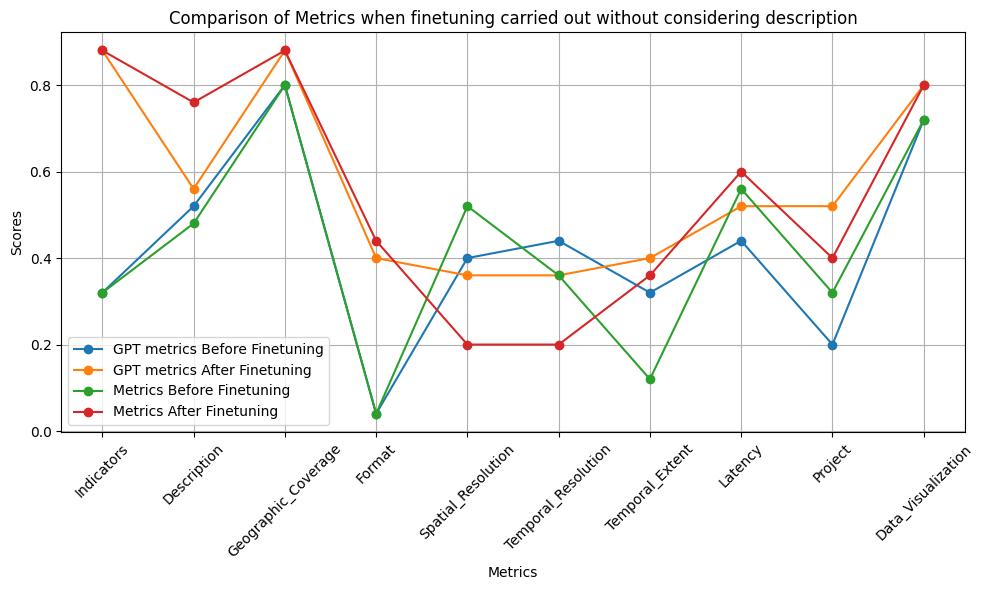

In [23]:
import matplotlib.pyplot as plt
keys = list(finals_gpt_before_metrics.keys())
gpt_before_values = list(finals_gpt_before_metrics.values())
gpt_after_values = list(finals_gpt_after_metrics.values())
metrics_before_values = list(metrics_before_finetuning.values())
metrics_after_values = list(metrics_after_finetuning.values())

# Plotting
plt.figure(figsize=(10, 6))

plt.plot(keys, gpt_before_values, marker='o', label='GPT metrics Before Finetuning')
plt.plot(keys, gpt_after_values, marker='o', label='GPT metrics After Finetuning')
plt.plot(keys, metrics_before_values, marker='o', label='Metrics Before Finetuning')
plt.plot(keys, metrics_after_values, marker='o', label='Metrics After Finetuning')

plt.title('Comparison of Metrics when finetuning carried out without considering description')
plt.xlabel('Metrics')
plt.ylabel('Scores')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()

# now we are going to aggregate the metrics using definition and gpt based evaluation for before and after finetuning scenario

In [24]:
before_finetuning,after_finetuning={},{}
for each_key in keys:
    definition_before=before_metrics[each_key]
    gpt_before=final_gpt_before_metrics[each_key]
    result = [max(x) for x in zip(definition_before, gpt_before)]
    before_finetuning[each_key]=result

    definition_after=after_metrics[each_key]
    gpt_after=final_gpt_after_metrics[each_key]
    result = [max(x) for x in zip(definition_after, gpt_after)]
    after_finetuning[each_key]=result

before_finetuning=get_metrics(before_finetuning)
after_finetuning=get_metrics(after_finetuning)

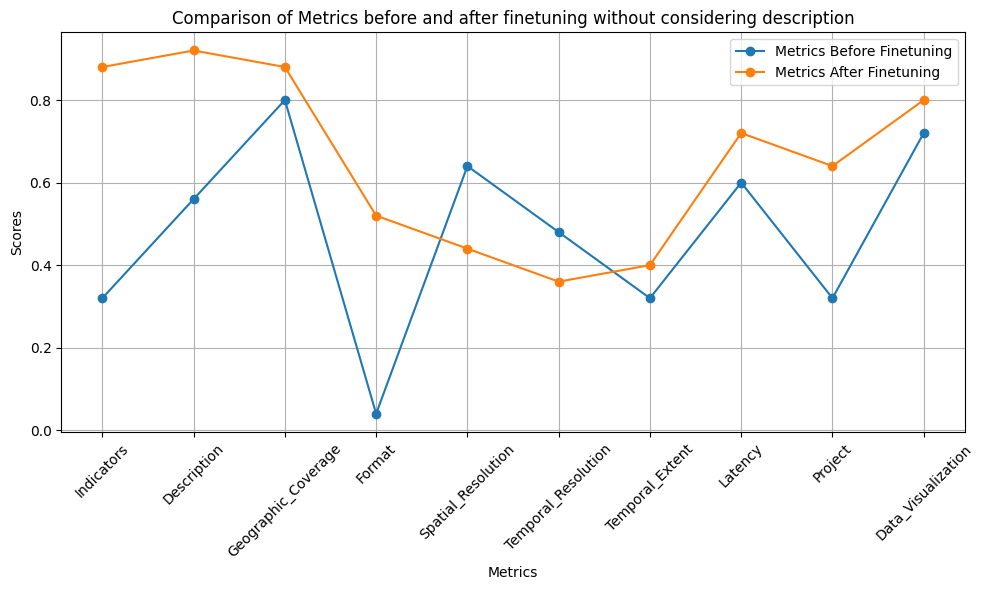

In [25]:
keys = list(before_finetuning.keys())
before_values = list(before_finetuning.values())
after_values = list(after_finetuning.values())

# Plotting
plt.figure(figsize=(10, 6))

plt.plot(keys, before_values, marker='o', label='Metrics Before Finetuning')
plt.plot(keys, after_values, marker='o', label='Metrics After Finetuning')


plt.title('Comparison of Metrics before and after finetuning without considering description')
plt.xlabel('Metrics')
plt.ylabel('Scores')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()